In [1]:
from choice_model import ChoiceModel
import networkx as nx
model = ChoiceModel()
actors = [a for a in model.graph.nodes if model.graph.nodes[a]['type'] == 'Actors']
print("number of actors: ", len(actors))
print("number of nodes: ",len(model.graph.nodes()))
model.visualize()

number of actors:  403
number of nodes:  868


# Get specific Period

In [2]:
graph = model.get_period(2)
print("number of nodes: ",len(graph.nodes()))

number of nodes:  165


# Roll Back

In [3]:
import pandas as pd
index_df = pd.DataFrame(columns=['period','PPI', 'CVI', 'DCI'])

In [4]:
for i in range(10):
    model.roll_back(i)
    index_df.loc[i] = [i] + list(model.evaluate())
    model.visualize(file_name=f"period_{i}.html")

index_df.head()

,period,PPI,CVI,DCI
0,0.0,0.324295,3.301887,0.081081
1,1.0,0.362038,3.980198,0.047619
2,2.0,0.344548,4.083333,0.029126
3,3.0,0.384506,4.483607,0.019108
4,4.0,0.401504,4.693431,0.015789


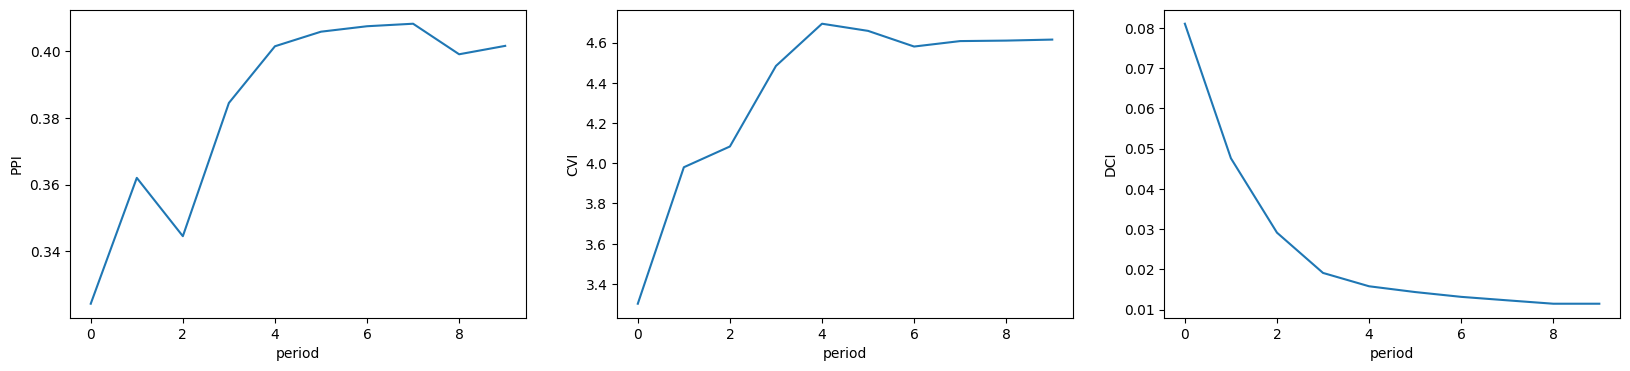

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,3, figsize=(20,4))

sns.lineplot(data=index_df, x='period', y='PPI', ax=ax[0])
sns.lineplot(data=index_df, x='period', y='CVI', ax=ax[1])
sns.lineplot(data=index_df, x='period', y='DCI', ax=ax[2])
# index_df.plot(x='period', y=['PPI', 'CVI', 'DCI'])
plt.show()

# Predict

### What if there's no Long-term Project in the beginning?

In [9]:
from choice_model import ChoiceModel
import networkx as nx
model = ChoiceModel()

### Initial State

In [10]:
# roll back to the initial state    
model.roll_back(0)
init_graph = model.graph.copy()
init_PPI, init_CVI, init_DCI = model.evaluate(init_graph)
print("PPI: ", init_PPI)
print("CVI: ", init_CVI)
print("DCI: ", init_DCI)

PPI:  0.3242945775964644
CVI:  3.30188679245283
DCI:  0.08108108108108109


### remove long-term project

In [11]:
# remove long-term-project
import pickle
nodes = [n for n in init_graph.nodes if init_graph.nodes[n]['type'] != 'Long-term Project']
test_graph = init_graph.subgraph(nodes).copy()
# Remove the edge if either node is not in the list
for edge in list(test_graph.edges()):
    source, destination = edge
    if source not in nodes or destination not in nodes:
        test_graph.remove_edge(source, destination)
isolated_nodes = [n for n in test_graph.nodes if test_graph.degree(n) == 0]
test_graph.remove_nodes_from(isolated_nodes)
with open("org_graph/org_graph_0.pkl",'wb') as f:
    pickle.dump(test_graph, f)

model = ChoiceModel(graph_path="org_graph/org_graph_0.pkl")
PPI, CVI, DCI = model.evaluate(test_graph)
isolated_nodes = model.get_isolated_nodes()
print("Isolated nodes: ", len(isolated_nodes))
print("PPI: ", PPI)
print("CVI: ", CVI)
print("DCI: ", DCI)
model.visualize(test_graph,file_name='org_graph/org_graph_0.html')

Isolated nodes:  0
PPI:  0.3701388888888889
CVI:  2.7884615384615383
DCI:  0.05555555555555555


### period 1

In [4]:
# get all nodes in period 1
# 先加载原图获取第二阶段的节点
model = ChoiceModel()
graph = model.get_period(1) #换成第二阶段
new_nodes = [n for n in graph.nodes if n not in nodes]
actor_ndoes = [n for n in graph.nodes if graph.nodes[n]['type'] == 'Actors']
other_nodes = [n for n in graph.nodes if graph.nodes[n]['type'] != 'Actors']
print("number of nodes: ",len(new_nodes))
print("number of actors: ", len(actor_ndoes))
print("number of other nodes: ",len(other_nodes))


number of nodes:  75
number of actors:  71
number of other nodes:  41


In [ ]:
# 把模型换成之前第一阶段的图进行计算
model = ChoiceModel(graph_path='保存的第一阶段文件路径')

### link prediction without llm

In [5]:
# # add each node to the test_graph

# from tqdm import tqdm
# import pickle
# import pandas as pd
# import numpy as np

# # use all history data as reference to predict
# model.roll_back(9)
# data_df = pd.DataFrame(columns=['node','profile','old_choices', 'old_probabilities', 'old_ids', 'new_options'])

# for node in tqdm(new_nodes):
#     # try:
#         profile = model.graph.nodes[node]['properties']
#         node_type = model.graph.nodes[node]['type']
#         test_options = list(test_graph.nodes)
#         test_graph.add_node(node, type=node_type, properties=profile, embedding=model.embed_model.embed_query(str(profile)))
#         choices,probabilities,ids = model.link_prediction(profile=profile, node_type=node_type, k1=10,k2=5, top_k=5)
#         choices = [ c['properties'] for c in choices]
#         # find most silimar options to choices
#         index = model._build_index(test_graph)
#         link_options = []
#         for choice in choices:
#             query_embed = model.embed_model.embed_query(str(choice))
#             query_embed = np.array(query_embed).reshape(1,-1)
#             d, i = index['index'].search(query_embed, 1)
#             similar_nodes = index['ids'][i][0]
#             link_options.extend(similar_nodes.tolist())
#         # add edges
#         for option in link_options:
#             test_graph.add_edge(node, option)
#         if len(data_df) % 50 == 0:
#             data_df.to_csv('without_llm_period_1.csv')
#             with open("without_llm_period_1.pkl", "wb") as f:
#                 pickle.dump(test_graph, f)
#     # except Exception as e:
#     #     print(e)
#     #     pass

# # save the embeded graph
# with open("without_llm_period_1.pkl", "wb") as f:
#     pickle.dump(test_graph, f)


In [6]:
# PPI, CVI, DCI = model.evaluate(test_graph)
# print("PPI: ", PPI)
# print("CVI: ", CVI)
# print("DCI: ", DCI)

### link prediction with llm

In [7]:
# add each node to the test_graph

from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np

# use all history data as reference to predict
model.roll_back(9)
data_df = pd.DataFrame(columns=['node', 'profile', 'choices', 'new_options','llm_choice', 'llm_response'])

for node in tqdm(new_nodes):
    try:
        profile = model.graph.nodes[node]['properties']
        node_type = model.graph.nodes[node]['type']
        test_options = list(test_graph.nodes)
        test_graph.add_node(node, type=node_type, properties=profile, embedding=model.embed_model.embed_query(str(profile)))
        old_context,choices = model.get_old_context(profile=profile, node_type=node_type, k1=10,k2=5, top_k=5)
        choices = [ c['properties'] for c in choices]
        # find most silimar options to choices
        index = model._build_index(test_graph)
        link_options = []
        for choice in choices:
            query_embed = model.embed_model.embed_query(str(choice))
            query_embed = np.array(query_embed).reshape(1,-1)
            d, i = index['index'].search(query_embed, 1)
            similar_nodes = index['ids'][i][0]
            link_options.extend(similar_nodes.tolist())
        new_options = [test_graph.nodes[n]['properties'] for n in link_options]
        # ask llm to predict links
        llm_choice, llm_response = model.get_llm_choice(profile=profile, new_options=new_options, old_context=old_context, k1=10, k2=5, node_type=node_type,top_k=5)
        # add edges
        llm_answer = llm_choice['answer']
        for answer,id in zip(llm_answer, link_options):
             if answer=='Yes':
                print("add edge", node, id)
                test_graph.add_edge(node, id)
        data_df.loc[len(data_df)] = [node, profile, choices, new_options,llm_choice, llm_response]
        if len(data_df) % 50 == 0:
            data_df.to_csv('without_llm_period_1.csv')
            with open("without_llm_period_1.pkl", "wb") as f:
                pickle.dump(test_graph, f)
    except Exception as e:
        print(e)
        pass

data_df.to_csv('response_with_llm.csv')
# save the embeded graph
with open("without_llm_period_1.pkl", "wb") as f:
    pickle.dump(test_graph, f)


  0%|          | 0/75 [00:04<?, ?it/s]

add edge 1029 177
add edge 1029 300


In [20]:
PPI, CVI, DCI = model.evaluate(test_graph)
print("PPI: ", PPI)
print("CVI: ", CVI)
print("DCI: ", DCI)

# Period 2